<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/LP_column_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Column generation method for Network Flow (Linear Programming)

This notebook is a companion for learning the column generation method for solving linear programs at scale. We will focus on the **minimum cost multicommodity flow problem** as classical example where column generation provides an advantage over simplex/interior point methods, see chapter 16 in the book from Ahuja, Magnanti, Orlin https://www.amazon.com/Network-Flows-Theory-Algorithms-Applications/dp/013617549X

Since we will be focusing on multicommodity flows, we take the opportunity to introduce several concepts for flow problems in python, like the use of adjacency list, node-arc incidence matrix, LP formulations of shortest path and max flow, and how to use existing libraries for combinatorial algorithms (eg Dijkstra).

In [ ]:
# first some needed packages
import math as m
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
!pip install igraph
import igraph as ig
import scipy as sp
from matplotlib import patheffects
from dataclasses import dataclass
from abc import ABC, abstractmethod
np.random.seed(124)           # to ensure reproducibility
#cp.installed_solvers()       # uncomment this to check which solvers you have enabled in your cvxpy environment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 40.3 MB/s eta 0:00:00


# Introduction

The flow problems we study here can be written in the form of a Linear Programming problem:
\begin{align}
 \text{min}_{x\in R^n} & c^Tx \\
 & A x \leq b
\end{align}
for $A \in R^{m \times n}$. In this section we will provide an introduction to flow problems by following this plan:
- Introduce a graph example, and use it to define a number of flow problems:
- Shortest path
- Maximum flow
- Minimum cost multicommodity flow (link formulation)
- Minimum cost multicommodity flow (path formulation)

While in this section we solve all the above problems with a solver, in the next section we will introduce the *Column generation method* for solving the path formulation of the minimum cost multicommodity flow.


## Introduction to graph concepts

We are given a directed graph $G=(V,E)$. For our toy example we consider the following graph $G$ with number on links indicating capacities:
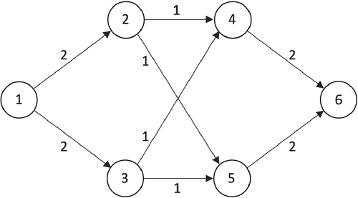

In [ ]:
# First, let us define different ways to describe our graph G


# Adjacency list of G
# It has one row for each link in the graph, we can also add attributes at each row as shown below with cost and capacity
# The adjacency list is the most memory efficient description of a graph, and greatly advantageous for sparse graphs
#
#                     origin dest cost capacity
Adj_list =  np.array([[ 1,    2,    1,    2],
                      [ 1,    3,    1,    2],
                      [ 2,    4,    5,    1],
                      [ 2,    5,    3,    1],
                      [ 3,    4,    2,    1],
                      [ 3,    5,    1,    1],
                      [ 4,    6,    1,    2],
                      [ 5,    6,    1,    2]])


# some parameters to be used later
M_cost = np.sum(Adj_list[:,2]) + 10     # a big M cost parameter (more than total network cost)
M_cap = np.sum(Adj_list[:,3]) + 10      # a big M capacity (more than total network capacity)


# number of nodes and links of G
G_nodes = 6
G_links = Adj_list.shape[0]    # the number of links is equal to the rows of Adj_list


# node-arc incidence matrix of graph G = (V,E)
# It is a V x E matrix
# Element (v,e) is equal to 1 if e departs from v and -1 if e arrives at v
# incidence matrix A helps write the flow conservation constraints in simple form Ax=0
A = np.zeros((G_nodes,G_links))   # node-arc incidence matrix
c = np.zeros(G_links)             # vector of link costs
b = np.zeros(G_links)             # vector of link capacities
for i in range(Adj_list.shape[0]):
    A[Adj_list[i,0]-1,i] = 1
    A[Adj_list[i,1]-1,i] = -1
    c[i] = Adj_list[i,2]
    b[i] = Adj_list[i,3]


print(f"The node-arc incidence matrix of G is A = \n {A}")

The node-arc incidence matrix of G is A = 
 [[ 1.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  1.  0.]
 [ 0.  0.  0. -1.  0. -1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -1. -1.]]


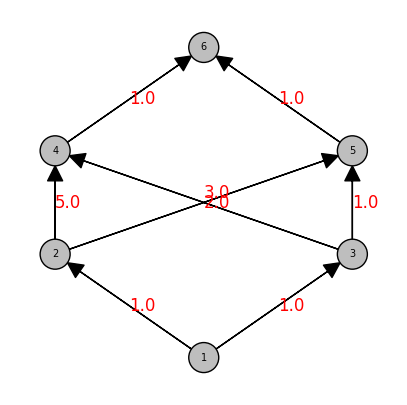

In [ ]:
# Construct g0 using igraph package (we will use g0 below when computing shortest paths)
edge_list = []
for i in range(Adj_list.shape[0]):
  edge_list.append((Adj_list[i,0]-1,Adj_list[i,1]-1))


g0 = ig.Graph(G_nodes, edge_list)                               # create the graph
g0.vs["name"] = [str(_) for _ in range(1,G_nodes+1)]            # name the nodes with numbers 1 to 6 (for illustration)
g0.es["cost"] = [float(Adj_list[_,2]) for _ in range(G_links)]  # add attribute cost
g0.es["cap"] = [float(Adj_list[_,3]) for _ in range(G_links)]   # add attribute capacity


# plot g0
g0.to_directed(mode="acyclic")      # make the graph directed (assign arrows)
fig, ax = plt.subplots(figsize=(5,5))
ig.plot(
    g0,
    target=ax,
    layout="sugiyama",
    vertex_size=30,
    vertex_color= "grey",
    vertex_frame_width=1.0,
    vertex_frame_color="black",
    vertex_label=g0.vs["name"],
    vertex_label_size=7.0,
    edge_width=1,
    edge_color="black",
    edge_label=g0.es["cost"],  # plot the costs
    edge_label_color="red"
    #edge_label=g0.es["cap"],    # plot the capacities
    #edge_label_color="blue"
)
plt.show()

## Shortest path using LP formulation

In this problem, we try to find a flow $x$ that connects a source node $s\in V$ to a destination node $t\in V$ with a path (sequence of links) of minimum cost (e.g. we may ask to flow 1 unit of volume through the network at minimum total cost).
For our example $s$ will be node 1, and $t$ will be node 6.

We formulate the shortest path as linear program as follows.

\begin{align}
\text{min}_{x\geq 0} & \sum_{(i,j)\in E} c_{ij}x_{ij} \\
\text{subject to} & \sum_j x_{ij} - \sum_j x_{ji} = \left\{ \begin{array}{ll}
1 & \text{if $i$ is source $s$} \\
-1 & \text{if $i$ is destination $t$} \\
0 & \text{otherwise}
\end{array}\right. & \forall i\in V
\end{align}

This can be formulated using the incidence matrix A as follows:
\begin{align}
\text{min}_{x\geq 0} & c^Tx \\
\text{subject to } & Ax = h
\end{align}
where $$h = \left[ \begin{array}{c}
1 \\
0 \\
0 \\
0 \\
0 \\
-1
 \end{array} \right]$$
 i.e., we assign 1 to the source and -1 to the destination.

 We note here that, in principle, in order to find a path (i.e. to avoid splitting the flow) we should also require that $x_{ij}\in\{0,1\}$ is binary. However, because $A$ is totally unimodular, we know that the LP above has integer optimal solutions. This means that if we solve the LP with a method like Simplex, we are ensured to get an integer optimal solution. Intuitively, if there exists a path of cost smaller than any other path, then all our demand should flow through this path to minimize cost. If there are many paths that all have equal minimum cost, then multiple solutions exist, some of which go through a unique path. See here for more detail: https://moodle2.units.it/pluginfile.php/383444/course/section/90789/MathOpt21_Lecture12_210322.pdf


In [ ]:
h = np.zeros(G_nodes)
h[0] = 1
h[-1] = -1

# Define the CVXPY problem.
x = cp.Variable(G_links)
prob = cp.Problem(cp.Minimize(c.T @ x), [A @ x <= h, x>=0])
# Solve the CVXPY problem using highs-ds simplex method
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs-ds"})


# Print result.
print("The optimal value is", prob.value)
print("An optimal solution x is:", x.value)
string_to_print = "The path is: "
for i in range(G_links):
  if x.value[i]>0:  # print all links that receive strictly positive flow
    string_to_print += "("+str(Adj_list[i,0])+","+str(Adj_list[i,1])+"),"
print(string_to_print[:-1])

The optimal value is 3.0
An optimal solution x is: [-0.  1. -0. -0. -0.  1. -0.  1.]
The path is: (1,3),(3,5),(5,6)


We can instead use igraph package to find a shortest path. Rather than LP, igraph uses Dijkstra for shortest path, which is a combinatorial algorithm. In fact, in what follows below, we will indeed be using igraph for shortest paths.

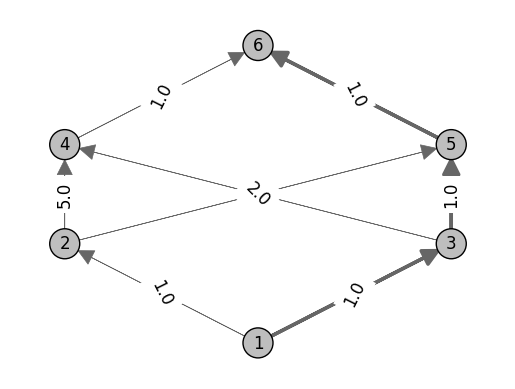

In [ ]:
# compute shortest path from 1 to 6
results = g0.get_shortest_paths(0, to=5, weights=g0.es["cost"], output="epath")


# plot the result
g0.es['width'] = 0.5
g0.es[results[0]]['width'] = 2.5
fig, ax = plt.subplots()
ig.plot(
    g0,
    target=ax,
    layout="sugiyama",
    vertex_color='grey',
    vertex_label=g0.vs["name"],
    edge_width=g0.es['width'],
    edge_label=g0.es["cost"],
    edge_color='#666',
    edge_align_label=True,
    edge_background='white'
)
plt.show()

## Maximum flow  using LP formulation

In this problem, we try to find a flow $x$ that connects a source node $s\in V$ to a destination node $t\in V$ sending the maximum amount of volume that the capacities of the graph allow. For our example $s$ will be node 1, and $t$ will be node 6.

We formulate the max flow problem as follows:
\begin{align}
\text{max}_{x,v\geq 0} & v \\
\text{subject to} & \sum_j x_{ij} - \sum_j x_{ji} = \left\{ \begin{array}{ll}
v & \text{if $i$ is source $s$} \\
-v & \text{if $i$ is destination $t$} \\
0 & \text{otherwise}
\end{array}\right. & \forall i\in V \\
& x_{ij} \leq b_{ij} & \forall (i,j) \in E
\end{align}

This can be formulated using the incidence matrix A as follows:
\begin{align}
\text{max}_{x,v\geq 0} & v \\
\text{subject to } & Ax = vh \\
& x\leq b
\end{align}
where $h$ is defined above, and $b$ is the vector of capacities.

In [ ]:
h = np.zeros(G_nodes)
h[0] = 1
h[-1] = -1

# Define and solve the CVXPY problem.
x = cp.Variable(G_links)
v = cp.Variable()
prob = cp.Problem(cp.Maximize(v), [A @ x == v*h, x<=b, x>=0, v>=0])
# Use an interior point method "highs-ipm"
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs-ipm"})


# Print result.
print("The optimal value is", prob.value)
print("An optimal flow x is:", x.value)
string_to_print = "The flow goes over: "
for i in range(G_links):
  if x.value[i]>0:
    string_to_print += "("+str(Adj_list[i,0])+","+str(Adj_list[i,1])+"),"
print(string_to_print[:-1])

The optimal value is 4.0
An optimal flow x is: [2. 2. 1. 1. 1. 1. 2. 2.]
The flow goes over: (1,2),(1,3),(2,4),(2,5),(3,4),(3,5),(4,6),(5,6)


Next we use igraph package to compute the maxflow. Rather than solving an LP, igraph uses a combinatorial algorithm from "A. V. Goldberg and R. E. Tarjan: A New Approach to the Maximum Flow Problem Journal of the ACM 35:921-940, 1988."

In [ ]:
# compute max flow from 1 to 6
flow = g0.maxflow(0, 5, capacity=g0.es["cap"])
print("Max flow from 1 to 6:", flow.value)
print("Edge assignments:", flow.flow)
#print(g0.st_mincut(0,5, capacity=g0.es["cap"]))

Max flow from 1 to 6: 4.0
Edge assignments: [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0]


## Minimum cost multi-commodity flow (link formulation)

In this problem, we extend the shortest path problem to multiple s-t commodities. Each commodity $d\in D$ has a source node $s^d\in V$ and a destination node $t^d\in V$, and a fixed demand $v^d$ that needs to flow through the network to go from $s^d$ to $t^d$. The goal is to find a flow for each commodity (which is called a multi-commodity flow) to meet the demand subject to capacity constraints while spending the  minimum overall cost.

For our example,  we are given a *traffic matrix* with demand that needs to be flown in the network. In our example we want to send 1.5 from node1 to node6 and 1.5 from node1 to node5.

The link formulation is as follows.

\begin{align}
\text{min}_{x\geq 0} & \sum_{(i,j)\in E} c_{ij}\sum_{d\in D} x_{ij}^d \\
\text{subject to} & \sum_j x_{ij}^d - \sum_j x_{ji}^d = \left\{ \begin{array}{ll}
v^d & \text{if $i$ is source $s^d$} \\
-v^d & \text{if $i$ is destination $t^d$} \\
0 & \text{otherwise}
\end{array}\right. & \forall i\in V, d\in D \\
& \sum_{d\in D}x_{ij}^d \leq b_{ij} & \forall (i,j) \in E
\end{align}

This can be formulated using the incidence matrix A as follows:
\begin{align}
\text{min}_{x\geq 0} & c^T\sum_d x^d \\
\text{subject to } & Ax^d = v^dh^d & \forall d\in D \\
& \sum_d x^d \leq b
\end{align}
where $$h^d_i = \left\{  \begin{array}{ll}
1 & \text{if $i$ is source $s^d$} \\
-1 & \text{if $i$ is destination $t^d$} \\
0 & \text{otherwise.}
\end{array} \right.$$

In [ ]:
# INPUT: demand of our example problem
vd = np.array([[ 1,    6,    1.5],
               [ 1,    5,    1.5]])
G_commodities = vd.shape[0]         # nof commodities


# form RHS for flow conservation
h = np.zeros((G_nodes,G_commodities))
for i in range(G_commodities):
  h[int(vd[i,0])-1,i] = vd[i,2]  # source of commodity i
  h[int(vd[i,1])-1,i] = -vd[i,2] # dest. of commodity i

# Define the CVXPY problem.
x = cp.Variable((G_links, G_commodities))           # defines the variables
constraints = []                                    # defines the constraints
constraints += [cp.sum(x,1) <= b]
constraints += [x>=0]
for i in range(G_commodities):
  #constraints += [A@x[:,i] == 0]
  constraints += [A@x[:,i] == h[:,i]]
obj = cp.Minimize(cp.sum(c.T @ cp.sum(x,1)))        # defines the objective
prob = cp.Problem(obj, constraints)                 # defines the cvxpy problem
# Solve the CVXPY problem
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})


# Print result.
print("The optimal value is", prob.value)
print("An optimal flow x is:", x.value)
link_formulation_solution = np.copy(x.value)  # store link formulation solution
string_to_print = "The first commodity flows over: "
for i in range(G_links):
  if x.value[i,0]>0:
    string_to_print += "("+str(Adj_list[i,0])+","+str(Adj_list[i,1])+"),"
print(string_to_print[:-1])
string_to_print = "The second commodity flows over: "
for i in range(G_links):
  if x.value[i,1]>0:
    string_to_print += "("+str(Adj_list[i,0])+","+str(Adj_list[i,1])+"),"
print(string_to_print[:-1])

##
## consider plotting with igraph the solution
##

The optimal value is 10.5
An optimal flow x is: [[ 0.5  0.5]
 [ 1.   1. ]
 [-0.  -0. ]
 [ 0.5  0.5]
 [ 1.  -0. ]
 [-0.   1. ]
 [ 1.  -0. ]
 [ 0.5 -0. ]]
The first commodity flows over: (1,2),(1,3),(2,5),(3,4),(4,6),(5,6)
The second commodity flows over: (1,2),(1,3),(2,5),(3,5)


## Minimum cost multi-commodity flow (path formulation)

Now we reformulate the above minimum cost MCF problem to use path variables $x_p^d,~~p\in P^d$, where $P^d$ is the set of paths that connect the origin of $d$ to the destination of $d$.

We will use the **Routing matrix** $R\in P\times E$. Here $R_{pe}=1$ if path $p$ utilizes directional link $e$ and $0$ otherwise. For our example it is:
\begin{align}
R = \left[\begin{array}{cccccccc}
1 & 0 & 1 & 0 & 0 & 0 & 1 & 0 \\
1 & 0 & 0 & 1 & 0 & 0 & 0 & 1 \\
0 & 1 & 0 & 0 & 1 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 1 \\
1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 \\
\end{array}\right]\end{align}
where rows 1-4 correspond to $P^1$ (paths of first commodity) and rows 5-6 to $P^2$ (paths of second commodity).


The path formulation is as follows.

\begin{align}
\text{min}_{x\geq 0} & \sum_{d\in D}\sum_{p\in P^d} \sum_{e\in E} c_{e} R_{pe} x_{p}^d \\
\text{subject to} & \sum_{p\in P^d} x_{p}^d = v^d &  \forall d \in D \\
& \sum_{d\in D} \sum_{p\in P^d} R_{pe}x_p^d \leq b_e & \forall e\in E
\end{align}

Using vector notation we can write the objective as:
\begin{align}
c^TR^Tx \boldsymbol{1}_D
\end{align}

the first constraint as:
\begin{align}
(R^d)^Tx_d  \leq v^d, ~~~ \forall d\in D
\end{align}
where, $R_d, x_d$ refer to routing and variables of commodity $d$ only.
And the second constraint as:
\begin{align}
R^Tx \boldsymbol{1}_D \leq b
\end{align}
where $\boldsymbol{1}_D$ is a row vector of ones with $|D|$ elements.

In [ ]:
# INPUT: demand of our example problem
vd = np.array([[ 1,    6,    1.5],
               [ 1,    5,    1.5]])


R = np.array([[ 1, 0, 1, 0, 0, 0, 1, 0],     # Routing matrix
              [ 1, 0, 0, 1, 0, 0, 0, 1],
              [ 0, 1, 0, 0, 1, 0, 1, 0],
              [ 0, 1, 0, 0, 0, 1, 0, 1],
              [ 1, 0, 0, 1, 0, 0, 0, 0],
              [ 0, 1, 0, 0, 0, 1, 0, 0]])


Pd = np.array([0, 0, 0, 0, 1, 1])            # membership of path-commodity


G_paths = R.shape[0]                         # nof paths
G_commodities = vd.shape[0]                  # nof commodities



# Define and solve the CVXPY problem.
x = cp.Variable((G_paths, G_commodities))                                             # defines the variables
constraints = []                                                                      # defines the constraints
for i in range(G_commodities):
  constraints += [cp.sum(x[[_ for _ in range(G_paths) if Pd[_]==i],i]) == vd[i,2]]    # flow conservation (needed only at the source of each commodity)
constraints += [cp.sum(R.T @ x,1) <= b]                                               # capacity constraints
constraints += [x>=0]                                                                 # non-negativity
obj = cp.Minimize(cp.sum(c.T @ (R.T@ x)))                                             # defines the objective
prob = cp.Problem(obj, constraints)                                                   # defines the cvxpy problem

# Use an lp method (solver switches between ipm and simplex)
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
path_formulation_solution = np.copy(x.value)  # store path formulation solution


# Print result.
print("The optimal value is", prob.value)
print("An optimal flow over paths xp is:\n", x.value)



The optimal value is 10.5
An optimal flow over paths xp is:
 [[-0.  -0. ]
 [ 0.5 -0. ]
 [ 1.  -0. ]
 [-0.  -0. ]
 [-0.   0.5]
 [-0.   1. ]]


The two formulations (link and path) are equivalent in that they achieve the optimal value. In a scenario that they are multiple optimal solutions, it is possible that the two problems can yield different solutions.

Given a path based solution $x$, we may derive its flow equivalent using  $f_{ij}^d=\sum_{p\in P^d} R_{pij}x_p^d$.

Given a flow based solution $f$, we may derive its path equivalent using the Path decomposition theorem. This involves defining a DAG graph based on the solution $f$, and then utilizing successive shortest paths to decompose the DAG into a set of paths, see Sec3.5 of Ahuja-Magnanti-Orlin "Network Flows" book.





In terms of solving the two problems, however, we observe a difference in their constraint matrix $A$. The edge-based formulation has  $|V||D|+|E|$ constraints and $|E||D|$ variables, while the path-based formulation has $|D|+|E|$ constraints and $|P||D|$ variables. Typical instances have $|E|=O(|V|^2)$ and $|D|=O(|V^2|)$, but $|P|$ can grow exponentially with $|V|$. Hence,  the path-based formulation has $|V|$ times less constraints than flow-based but massively more variables. That means that $A$ has more rows in the edge-based formulation, and more columns in the path-based one, and hence the path-based formulation would be speeding up the problem if we had a way to reduce the number of columns. We also know that LPs are solved with a basis, i.e., a small subset of non-zero variables; if we had this magical set of columns, we would not need all the rest. Next, we present *Column Generation* a  technique where we start with the path-based formulation and  a small subset of columns that provides feasibility, and then we iterate progressively adding new useful columns. Each iteration consists of two subproblems, (i) the  *restricted LP* where we solve the path-based MCF with only a subset of columns activated to determine certain Lagrange multipliers, and (ii) the *pricing problem* where we find shortest paths on a modified graph (with the multipliers of the restricted LP) to determine the next columns to add.

# Column generation for path formulation of Min Cost MCF

Recall $P^d$ is the set of paths on $G$ that connect origin and destination for commodity $d\in D$ and $P=\cup_{d\in D} P^d$ the set of all paths we consider. At iteration $k$ of the algorithm we will consider subsets $P^d(k)\subseteq P^d, d\in D$. Due to this path restriction, we call the respective path formulation *Restricted LP*:

\begin{align}
\text{min}_{x\geq 0} & c^TR^T(k)x(k) \boldsymbol{1}_D \\
\text{subject to}~~ & (R^d(k))^Tx_d(k)  \geq v^d, ~~~ \forall d\in D \\
& R^T(k)x(k) \boldsymbol{1}_D \leq b
\end{align}

where $R(k)$ is the routing matrix restricted to the considered paths and $x(k)$ is the vector of path variables restricted to the considered paths. Notice, we use $\geq$ rather than $=$ for the flow conservation constraint. The reason we do this is to remove ambiguity around the sign of the dual variable for this constraint (though the algorithm would work without doing this). Using $\geq$ does not change the solution because pumping more volume than $v^d$ will lead to higher cost, which our solver avoids.

- Let $x^*(k)$ be the optimal solution to the restricted LP at iteration $k$.

- Let $\lambda(k)$ be the $m\times 1$ vector of dual variables for the capacity constraint $R^T(k)x(k) \boldsymbol{1}_D \leq b$,  at iteration $k$.

- Let $\mu(k)$ be the $|D| \times 1$ vector of dual variables for the flow conservation constraint $(R^d(k))^Tx_d(k)  \geq v^d, ~ \forall d\in D $,  at iteration $k$.





### Algorithm: Column Generation for Multicommodity Min-cost Flow

Input: $c, R, \alpha, b, D, P$

**Step 1:** Initialize with a feasible basis (use ``dummy paths'')

**While** Exists $d\in D$:  $\sum_{ij}(c_{ij}+\lambda_{ij}(k)) R_{p^*ij}\geq -\mu^d(k)$ **do**

  **Step 2:** Add $p^{d*}$ and remove paths that are not used

  **Step 3:** Solve the restricted LP for the new set of paths to determine $\lambda(k),\mu(k)$
    
  **Step 4:** $\forall d\in D$, find shortest path $p^{d*}$ on graph $G$ with costs $c_{ij}+\lambda_{ij}(k)$

**End While**



#### Dummy paths
Initially, we want to find a small set of paths that guarantees our restricted LP is feasible. This is important so that we obtain finite dual variables, and be able to continue our iterations.

In [ ]:
# first, add dummy links to graph g0 to enable dummy paths
if(g0.ecount()<9): g0.add_edges([(0, 5), (0, 4)]) # we have added a check to avoid adding more links every time we run this cell
g0.es[8]["cap"] = np.sum(vd)    # pick a capacity that is larger than total demand
g0.es[8]["cost"] = M_cost       # pick a cost that is equal to using the entire network
g0.es[9]["cap"] = np.sum(vd)    # pick a capacity that is larger than total demand
g0.es[9]["cost"] = M_cost       # pick a cost that is equal to using the entire network
b = np.array(g0.es[:]["cap"])   # update b vector with capacities (to include dummy paths)
c = np.array(g0.es[:]["cost"])  # update c vector with costs (to include dummy paths)
print(f"""b = {b}
c = {c}""")

b = [ 2.  2.  1.  1.  1.  1.  2.  2. 16. 16.]
c = [ 1.  1.  5.  3.  2.  1.  1.  1. 25. 25.]


In [ ]:
# INPUT: demand of our example problem
vd = np.array([[ 1,    6,    1.5],
               [ 1,    5,    1.5]])
G_commodities = vd.shape[0]         # nof commodities
G_nodes = g0.vcount()               # nof nodes
G_links = g0.ecount()               # nof links



# initially each commodity has only the dummy path
Rk = np.array([[ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
               [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])  # routing matrix with only dummy paths
Pd = np.array([0, 1])                             # first path belongs to commodity 0 (ie first commodity) and second path to commodity 1

G_paths = Rk.shape[0]                # nof paths
print(f"""Number of commodities: {G_commodities}
Number of nodes:       {G_nodes}
Number of links:       {G_links}
Number of paths:       {G_paths}""")

Number of commodities: 2
Number of nodes:       6
Number of links:       10
Number of paths:       2


#### Solve restricted LP

We solve the path-formation of the restricted LP, where we only have for the moment the dummy paths.

In [ ]:
# Define the CVXPY problem
x = cp.Variable((G_paths, G_commodities))                                             # defines the variables
constraints = []                                                                      # defines the constraints
for i in range(G_commodities):
  constraints += [cp.sum(x[[_ for _ in range(G_paths) if Pd[_]==i],i]) >= vd[i,2]]    # flow conservation (needed only at the source of each commodity)
constraints += [cp.sum(Rk.T @ x,1) <= b]                                              # capacity constraints
constraints += [x>=0]                                                                 # non-negativity
obj = cp.Minimize(cp.sum(c.T @ (Rk.T@ x)))                                            # defines the objective
prob = cp.Problem(obj, constraints)                                                   # defines the cvxpy problem
# Solve CVXPY problem
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
#path_formulation_solution = np.copy(x.value)  # store path formulation solution


# Print result
print("The optimal value is", prob.value)
print("An optimal flow over paths xp is:", x.value)
# extract dual variables of capacity constraints
lambdak = constraints[G_commodities].dual_value # we use "G_commodities" to select the constraint cp.sum(Rk.T @ x,1) <= b
muk = np.zeros(G_commodities)
for i in range(G_commodities):
  muk[i] = constraints[i].dual_value # we use ":G_commodities-1" to select the constraint (R^d(k))^Tx_d(k) <= v^d
print("The dual values of cap constraints are:",lambdak)
print("The dual values of flow constraints are:",muk)


The optimal value is 75.0
An optimal flow over paths xp is: [[ 1.5 -0. ]
 [-0.   1.5]]
The dual values of cap constraints are: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The dual values of flow constraints are: [25. 25.]


#### Compute shortest paths on the augmented graph

As part of step 4, we want to compute the shortest s-t path on graph g0 with modified weights, where the cost of link $(i,j)$ is equal to $c_{ij}+\lambda_{ij}$, where $\lambda_{ij}$ is the dual variable of the capacity constraint.

In [ ]:
# compute augmented graph
g0.es[range(G_links)]["cost"] = c + lambdak



# for each commodity: find a shortest path on the augmented graph and add the path on our arrays
for i in range(G_commodities):
  # find shortest path for commodity i
  new_path = g0.get_shortest_paths(int(vd[i,0]-1), int(vd[i,1]-1), weights=g0.es["cost"], output="epath") # the answer is in form of [1,3,7]
  # add the paths
  newrow = np.zeros(G_links)                  # initialize
  newrow[new_path] = 1                        # shortest path in form [0, 1, 0, 1, 0, 0, 0, 1]

  if(np.sum(c.T @ newrow) < muk[i]):   # add the path if cost(path[d]) < muk[d]
    if any(np.equal(Rk,newrow).all(1)):         # checks if the path exists in Rk already
      print("Warning: the path exists already")
    else:
      Rk = np.vstack([Rk, newrow])              # add the path
      Pd = np.append(Pd, i)                     # add the commodity
  else: print("Warning: the shortest path will not help since its cost is higher than muk")



#check
print(Pd)
print(Rk)


[0 1 0 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]]


#### Solve the restricted LP again, and repeat

In [ ]:
G_paths = Rk.shape[0]                # nof paths
# Define the CVXPY problem
x = cp.Variable((G_paths, G_commodities))                                             # defines the variables
constraints = []                                                                      # defines the constraints
for i in range(G_commodities):
  constraints += [cp.sum(x[[_ for _ in range(G_paths) if Pd[_]==i],i]) >= vd[i,2]]    # flow conservation (needed only at the source of each commodity)
constraints += [cp.sum(Rk.T @ x,1) <= b]                                              # capacity constraints
constraints += [x>=0]                                                                 # non-negativity
obj = cp.Minimize(cp.sum(c.T @ (Rk.T@ x)))                                            # defines the objective
prob = cp.Problem(obj, constraints)                                                   # defines the cvxpy problem
# Solve the CVXPY problem
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})


# Print result
print("The optimal value is", prob.value)
print("An optimal flow over paths xp is:", x.value)
# extract dual variables of capacity constraints
lambdak = constraints[G_commodities].dual_value # we use "G_commodities" to select the constraint cp.sum(Rk.T @ x,1) <= b
muk = np.zeros(G_commodities)
for i in range(G_commodities):
  muk[i] = constraints[i].dual_value # we use ":G_commodities-1" to select the constraint (R^d(k))^Tx_d(k) <= v^d
print("The dual values of cap constraints are:",lambdak)
print("The dual values of flow constraints are:",muk)


The optimal value is 52.0
An optimal flow over paths xp is: [[ 1.5 -0. ]
 [-0.   0.5]
 [-0.  -0. ]
 [-0.   1. ]]
The dual values of cap constraints are: [ 0.  0.  0.  0.  0. 23.  0.  0.  0.  0.]
The dual values of flow constraints are: [25. 25.]


Now, lets put together everything together in types and functions.

First, we define the problem.

In [ ]:
# class for Minimum Cost Multicommodity Flow problems (MCF)
# *********************************************************
#
# List of inputs required to build the object
# ---
# Adj_list: adjacency list describing the graph g
# G_nodes: number of nodes in the graph g
# vd: np.array describing the demand
#
# List of properties
# ---
# g: igraph Graph with nodes G_nodes and links defined by Adj_list, attributes on links for cost and capacity
# b: np.array with capacities per link (RHS of the LP constraint)
# c: np.array with costs per link (LP objective coefficients)
# g is augmented with virtual links, one for each demand in vd (hence g ends up having vd.shape[0] more links than the Adj_list would define)
# Rk: np.array (paths,links) initialized to have only 1 path per commodity (dummy path that connects source to destination)
# Pd: np.array (paths,commodities) initialized to have only 1 path per commodity (dummy path that connects source to destination)
#
# List of parameters
# ---
# M_cost: a big cost number set to 25
# *********************************************************
class flow_problem:
    M_cost = 25        # big cost parameter

    def __init__(self, Adj_list, G_nodes, vd):
      # construct igraph g
      edge_list = []
      for i in range(Adj_list.shape[0]):
        edge_list.append((Adj_list[i,0]-1,Adj_list[i,1]-1))

      self.g = ig.Graph(G_nodes, edge_list)                                         # create the igraph
      self.g.vs["name"] = [str(_) for _ in range(1,G_nodes+1)]                      # name the nodes with numbers 1 to 6 (for illustration)
      self.g.es["cost"] = [float(Adj_list[_,2]) for _ in range(Adj_list.shape[0])]  # add attribute cost at each link
      self.g.es["cap"] = [float(Adj_list[_,3]) for _ in range(Adj_list.shape[0])]   # add attribute capacity at each link

      # initialize Routing matrix Rk and augment the graph with dummy paths
      self.Rk = np.zeros((vd.shape[0],Adj_list.shape[0]+vd.shape[0]))
      self.Pd = np.zeros(vd.shape[0])
      for i in range(vd.shape[0]):
        self.g.add_edges([(int(vd[i,0]-1),int(vd[i,1]-1))]) # add an edge that connects the source of commodity i to its destination
        self.g.es[-1]["cap"] = np.sum(vd)                   # pick a large capacity
        self.g.es[-1]["cost"] = M_cost                      # pick a large cost
        self.Rk[i,Adj_list.shape[0]+i] = 1                  # for commodity i, just open a path that utilizes a virtual link
        self.Pd[i] = i                                      # dummy path i belongs to commodity i

      # construct vectors c,b
      self.b = np.array(self.g.es[:]["cap"])
      self.c = np.array(self.g.es[:]["cost"])

    @property
    def nodes(self) -> int:
      return self.g.vcount()

    @property
    def links(self) -> int:
      return self.g.ecount()

    @property
    def coms(self) -> int:
      return self.vd.shape[0]



# Example specifics

# Define the graph we want via Adj_list (visually easy)
#                     origin dest cost capacity
Adj_list =  np.array([[ 1,    2,    1,    2],
                      [ 1,    3,    1,    2],
                      [ 2,    4,    5,    1],
                      [ 2,    5,    3,    1],
                      [ 3,    4,    2,    1],
                      [ 3,    5,    1,    1],
                      [ 4,    6,    1,    2],
                      [ 5,    6,    1,    2]])

# how many nodes?
G_nodes = 6

# demand matrix, rows = commodities, col1 = source, col2 = dest, col3 = demand
vd = np.array([[ 1,    6,    1.5],
               [ 1,    5,    1.5]])

# build the object with our example problem / WARNING: this might not scale for very large graphs
MCF1 = flow_problem(Adj_list, G_nodes, vd)

In [ ]:
# print the initial routing matrix
print(MCF1.Rk)
print(MCF1.Pd)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[0. 1.]


In [ ]:
def solve_restricted_lp(
    MCF: flow_problem,
    vd: np.array
):
  """Solve a restricted LP based on the paths available in Rk, Pd

    Args:
        flow_problem object carries the following properties:
        b:  vector of capacities in R^E, where E is the number of links
        c:  vector of costs in R^E
        Rk: routing matrix P x E, where rows are the P paths, columns are the links, there is 1 if a link is used by a path
        Pd: path-commodity vector in {0, .., D-1}^P, where element p has Pd(p) = i if path p is for commodity i

        vd: commodity matrix D x 3, where rows are the D commodities, columns are source | destination | demand


    Returns:
        x.value: solution of the LP, matrix P x D, where element x[p,d] is the flow value of commodity d over path p
        lambdak: vector of dual variables for capacity constraints in R_+^E
        muk: vector of dual variables for flow constraints in R^D
  """
  G_paths = MCF.Rk.shape[0]            # nof paths
  G_commodities = vd.shape[0]          # nof commodities



  # Define the CVXPY problem
  x = cp.Variable((G_paths, G_commodities))                                               # defines the variables
  constraints = []                                                                        # initializes the constraints
  for i in range(G_commodities):
    constraints += [cp.sum(x[[_ for _ in range(G_paths) if MCF.Pd[_]==i],i]) >= vd[i,2]]  # flow conservation (needed only at the source of each commodity)
  constraints += [cp.sum(MCF.Rk.T @ x,1) <= MCF.b]                                        # capacity constraints
  constraints += [x>=0]                                                                   # non-negativity
  obj = cp.Minimize(cp.sum(MCF.c.T @ (MCF.Rk.T@ x)))                                      # defines the objective
  prob = cp.Problem(obj, constraints)                                                     # defines the cvxpy problem
  # Solve the CVXPY problem
  prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
  lambdak = constraints[G_commodities].dual_value                                         # we use "G_commodities" to select the constraint cp.sum(Rk.T @ x,1) <= b
  muk = np.zeros(G_commodities)
  for i in range(G_commodities):
    muk[i] = constraints[i].dual_value                                                    # we use ":G_commodities-1" to select the constraint (R^d(k))^Tx_d(k) <= v^d

  return x.value, lambdak, muk






def solve_pricing(
    MCF: flow_problem,
    lambdak: np.array,
    muk: np.array,
    vd: np.array
):
  """Find the shortest path for each commodity on a graph with costs c_ij+lambda_ij

    Args:
        flow_problem object carries the following properties:
        g:  igraph Graph with nodes, links, costs, and capacities
        Rk: routing matrix P x E, where rows are the P paths, columns are the links, there is 1 if a link is used by a path
        Pd: path-commodity vector in {0, .., D-1}^P, where element p has Pd(p) = i if path p is for commodity i

        lambdak: vector of dual variables for capacity constraints in R_+^E
        muk: vector of dual variables for flow constraints in R_+^D
        vd: commodity matrix D x 3, where rows are the D commodities, columns are source | destination | demand

    Returns:
        flow_problem object with updated:
        Rk: routing matrix with new paths (1 per commodity)
        Pd: path-commodity vector with indexing of new paths with appropriate commodities

        Reduced_cost: vector in R^D with reduced cost for each shortest path found
  """
  # compute augmented graph
  G_links = MCF.g.ecount()                                        # nof links
  G_commodities = vd.shape[0]                                     # nof commodities
  MCF.g.es[range(G_links)]["cost"] = MCF.c + lambdak              # augment the cost of graph
  Reduced_cost = np.zeros(G_commodities)                          # initialize the reduced cost of new paths

  # for each commodity: find a shortest path on the augmented graph and add the path on our arrays
  for i in range(G_commodities):
    # find shortest path for commodity i
    new_path = MCF.g.get_shortest_paths(int(vd[i,0]-1), int(vd[i,1]-1), weights=MCF.g.es["cost"], output="epath") # the answer is in form of [1,3,7]
    newrow = np.zeros(G_links)                                    # initialize a row vector
    newrow[new_path] = 1                                          # shortest path in form [0, 1, 0, 1, 0, 0, 0, 1]
    Reduced_cost[i] = np.sum((MCF.c+lambdak).T @ newrow)-muk[i]   # reduced cost for this path
    if(Reduced_cost[i] < 0):                                      # add the path if it has neg reduced cost, i.e., if sum [c_ij) + lambdak_ij] < muk_d
      if any(np.equal(MCF.Rk,newrow).all(1)):                     # checks if the path exists in Rk already
        print("Warning: the path exists already")
      else:
        MCF.Rk = np.vstack([MCF.Rk, newrow])                      # add the path
        MCF.Pd = np.append(MCF.Pd, i)                             # add the commodity
    else: print("Warning: the shortest path will not help since its modified cost is higher than muk")



  return MCF, Reduced_cost


Try the functions

In [ ]:
# check that the graph of our problem is how we want
print(MCF1.g.get_edgelist())
print(MCF1.g.es[:]["cost"])
print(MCF1.g.es[:]["cap"])

[(0, 1), (0, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 5), (4, 5), (0, 5), (0, 4)]
[1.0, 1.0, 5.0, 3.0, 2.0, 1.0, 1.0, 1.0, np.int64(25), np.int64(25)]
[2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, np.float64(16.0), np.float64(16.0)]


In [ ]:
print(vd)

[[1.  6.  1.5]
 [1.  5.  1.5]]


In [ ]:
# initialize again the problem
MCF1 = flow_problem(Adj_list, G_nodes, vd)

for i in range(4):
  print(f"\n \n Iteration {i}")
  print("###########################")
  xk, lambdak, muk = solve_restricted_lp(MCF1, vd)
  print(f"For paths \n Rk = {MCF1.Rk} \n the optimal solution is xk = {xk}")
  print(f"The dual variables of the capacity constraints are {lambdak}")
  print(f"The dual variables of the flow constraints are {muk}")
  print(f"\n !!!The value at iteration {i} is f(x) = {np.sum(c.T @ (MCF1.Rk.T@ xk))}\n")


  MCF1, Reduced_cost = solve_pricing(MCF1,lambdak,muk, vd)
  print(f"The reduced cost per commodity are: {Reduced_cost}")
  print(f"The pricing problem results in the following paths: \n Rk = {MCF1.Rk}")

  if(np.min(Reduced_cost) >=0):
    print("\n\n Stop the algorithm since we have non-negative reduced costs")
    break



 
 Iteration 0
###########################
For paths 
 Rk = [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] 
 the optimal solution is xk = [[ 1.5 -0. ]
 [-0.   1.5]]
The dual variables of the capacity constraints are [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The dual variables of the flow constraints are [25. 25.]

 !!!The value at iteration 0 is f(x) = 75.0

The reduced cost per commodity are: [-22. -23.]
The pricing problem results in the following paths: 
 Rk = [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]]

 
 Iteration 1
###########################
For paths 
 Rk = [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]] 
 the optimal solution is xk = [[ 1.5 -0. ]
 [-0.   0.5]
 [-0.  -0. ]
 [-0.   1. ]]
The dual variables of the capacity constraints are [ 0.  0.  0.  0.  0. 23.  0.  0.  0.  0.]
The dual variable

In [ ]:
np.sum(Adj_list[:, 2])

np.int64(15)